In [1]:
import numpy as np
import torch
import torchvision.datasets as datasets
from torch.utils.data import DataLoader, random_split
import pandas as pd
import torchvision
from torchvision import transforms
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import accuracy_score
from sklearn.metrics import silhouette_score, davies_bouldin_score, calinski_harabasz_score
from sklearn.mixture import GaussianMixture
import warnings
warnings.filterwarnings("ignore")
np.random.seed(42)
sns.set_style('darkgrid')

In [2]:
from clustering_utils import umap,tSNE,compute_most_represented_class_per_cluster,substitute_classes_labels
from cVAE_architecture import cVAE, loss_vae
from cVAE_train_utils import train_cVAE

device = 'cuda:0' if torch.cuda.is_available() else 'cpu'
batch_size = 128
cmap = plt.cm.get_cmap('viridis', 10)

In [3]:
from sklearn.manifold import TSNE
def tSNE(z, latent_space, clustering_labels, true_labels=None, cmap='viridis', aff_true_labels=True,data=None):
    # t-SNE projection
    tSNE_2d = TSNE(n_components=2) 
    proj_2d = tSNE_2d.fit_transform(z)  
    
    params = {'backend': 'Agg', "font.family": "calibri"}  # extend as needed
    plt.rcParams["axes.edgecolor"] = "0.15"
    plt.rcParams["axes.linewidth"] = 1.25
    fig = plt.figure()
    fig, ax = plt.subplots(layout="constrained")
    scatter = ax.scatter(x=proj_2d[:, 0], y=proj_2d[:, 1], s=15, c=clustering_labels, alpha=0.8, cmap=cmap)
    legend1 = ax.legend(*scatter.legend_elements(), loc="upper left", title="Classes", fontsize=5)
    
    ax.set_facecolor("white")
    ax.add_artist(legend1)
    plt.title(f'Prediction (latent space={latent_space})', fontsize=20)
    plt.xlabel('tSNE_1', fontsize=24)
    plt.xticks(fontsize=12)
    plt.yticks(fontsize=12)
    plt.ylabel('tSNE_2', fontsize=24)
    plt.savefig('./Results/tSNE_prediction_Zdim'+str(latent_space)+str(data)+'.png')
    plt.show()

    # Display the true labels if aff_true_labels is True
    if aff_true_labels:
        fig, ax = plt.subplots(layout="constrained")
        
        scatter = ax.scatter(x=proj_2d[:, 0], y=proj_2d[:, 1], s=15, c=true_labels, alpha=0.8, cmap="winter")
        legend1 = ax.legend(*scatter.legend_elements(), loc="upper left", title="Classes", fontsize=5)
        
        ax.set_facecolor("white")
        ax.add_artist(legend1)
        plt.title(f'True Label (latent space={latent_space})', fontsize=20)
        plt.xlabel('tSNE_1', fontsize=24)
        plt.xticks(fontsize=12)
        plt.yticks(fontsize=12)
        plt.ylabel('tSNE_2', fontsize=24)
        plt.savefig('./Results/tSNE_gt_Zdim'+str(latent_space)+str(data)+'.png')
        plt.show()
    
    if aff_true_labels and true_labels is not None:
        fig, ax = plt.subplots(layout="constrained")
        tri = ax.tricontourf(proj_2d[:, 0], proj_2d[:, 1], true_labels, levels=np.arange(-0.5, 2), zorder=0, cmap="YlGnBu", alpha=0.3)
        legend1 = ax.legend(*tri.legend_elements(), loc="upper left", title="Classes", fontsize=5)
    else:
        legend1 = ax.legend([], [], loc="upper left", title="Classes", fontsize=5)

    ax.set_facecolor("white")
    ax.add_artist(legend1)
    plt.title(f'True Label (latent space={latent_space})', fontsize=20)
    plt.xlabel('tSNE_1', fontsize=24)
    plt.xticks(fontsize=12)
    plt.yticks(fontsize=12)
    plt.ylabel('tSNE_2', fontsize=24)

    scatter = ax.scatter(x=proj_2d[:, 0], y=proj_2d[:, 1], s=15, c=clustering_labels, alpha=0.8, cmap=cmap)
    legend2 = ax.legend(*scatter.legend_elements(), loc="upper left", title="Classes", fontsize=5)
    
    ax.set_facecolor("white")
    ax.add_artist(legend2)
    plt.title(f'Prediction (latent space={latent_space})', fontsize=20)
    plt.xlabel('tSNE_1', fontsize=24)
    plt.xticks(fontsize=12)
    plt.yticks(fontsize=12)
    plt.ylabel('tSNE_2', fontsize=24)

    plt.savefig('./Results/tSNE_combined_Zdim'+str(latent_space)+str(data)+'.png')
    plt.show()
        
        

## Wild vs PIK3CA

In [4]:
# Define a transform to preprocess the data
transform = transforms.Compose([
                                transforms.Grayscale(num_output_channels=1),
                                transforms.Resize((192, 192)),
                                transforms.ToTensor()])

dataset = datasets.ImageFolder(root='cell_data_balanced_2classes_Wild_PIK3CA', transform=transform)

train_proportion = 0.8
test_proportion = 1 - train_proportion

# Calculate the number of samples for each split
total_samples = len(dataset)
train_samples = int(train_proportion * total_samples)
test_samples = total_samples - train_samples

# Use random_split to create train and test datasets with the calculated proportions
train_dataset, test_dataset = random_split(dataset, [train_samples, test_samples])

# Create DataLoader instances to load batches during training and testing
batch_size = 128
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

X_train = []
Y_train = []
for images, labels in train_loader:
    X_train.append(images)
    Y_train.append(labels)
X_train = torch.cat(X_train, dim=0)
Y_train = torch.cat(Y_train, dim=0)

X_test = []
Y_test = []
for images, labels in test_loader:
    X_test.append(images)
    Y_test.append(labels)
X_test = torch.cat(X_test, dim=0)
Y_test = torch.cat(Y_test, dim=0)

# Print shapes for verification
print("X_train shape:", X_train.shape)
print("Y_train shape:", Y_train.shape)
print("X_test shape:", X_test.shape)
print("Y_test shape:", Y_test.shape)

X_train shape: torch.Size([4278, 1, 192, 192])
Y_train shape: torch.Size([4278])
X_test shape: torch.Size([1070, 1, 192, 192])
Y_test shape: torch.Size([1070])


In [5]:

autoencoder_cvae=cVAE(num_labels=2, latent_dim=64,input_size=192)
autoencoder_cvae.load_state_dict(torch.load('./models/cVAE_Wild_PIK3CA_zdim_64_beta_1.0_epochs_100.pth',map_location=torch.device('cpu')))


<All keys matched successfully>

Clustering using GaussianMixture


<Figure size 432x288 with 0 Axes>

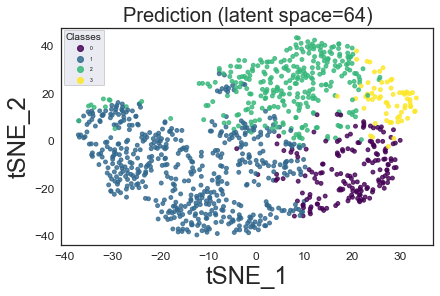

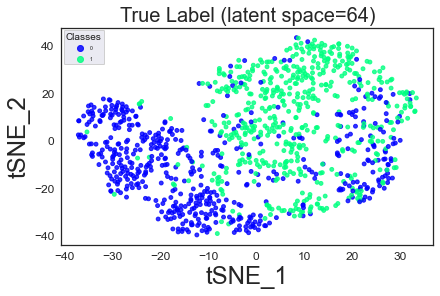

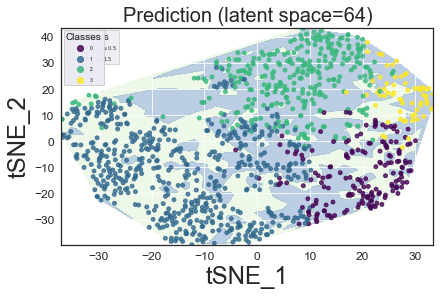

In [6]:
z_test = autoencoder_cvae.encode(X_test,Y_test)
#z_train = autoencoder_cvae.encode(X_train,Y_train)
n_clusters = 4
z_test = z_test.detach().numpy()
#z_train = z_train.detach().numpy()
y_test = Y_test.detach().numpy()
clustering = GaussianMixture(n_components=n_clusters, covariance_type='full').fit(z_test)
clustering_labels = clustering.predict(z_test)
tSNE(z_test,clustering_labels=clustering_labels,true_labels=y_test,latent_space=64,data="cells")


Samples of each cluster


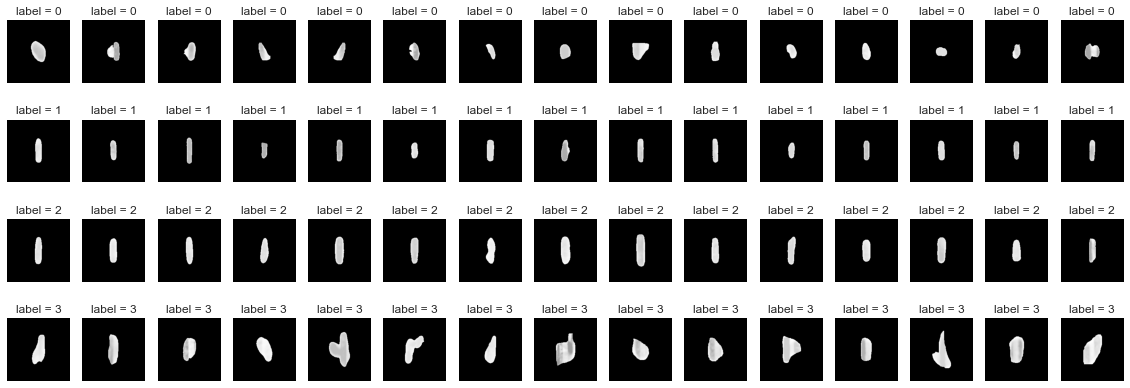

Silhouette: 0.2618, DB: 1.6211, CH: 255.8505


In [7]:
# Samples from each cluster
nb_samples = 15
l = list(set(clustering_labels))
fig, axes = plt.subplots(n_clusters,nb_samples, figsize=(20,7))
for label2 in l:
    for sample_index in range(nb_samples):
        axes[label2][sample_index].imshow(X_test[np.where(clustering_labels == label2)[0][sample_index]][0], cmap='gray')
        axes[label2][sample_index].set_title("label = "+str(label2))
        axes[label2][sample_index].grid(False)
        axes[label2][sample_index].axis('off')
        #axes[label][sample_index].set_title(f"Sample {sample_index} for cluster {label}")

plt.show()

s_16 = silhouette_score(z_test, clustering_labels)
db_16 = davies_bouldin_score(z_test, clustering_labels)
ch_16 = calinski_harabasz_score(z_test, clustering_labels)
print(f"Silhouette: {s_16:.4f}, DB: {db_16:.4f}, CH: {ch_16:.4f}")

## Wild vs DCIS

In [8]:

# Define a transform to preprocess the data
transform = transforms.Compose([
                                transforms.Grayscale(num_output_channels=1),
                                transforms.Resize((192, 192)),
                                transforms.ToTensor()])

dataset = datasets.ImageFolder(root='cell_data_balanced_2classes_Wild_DCIS', transform=transform)

train_proportion = 0.8
test_proportion = 1 - train_proportion

# Calculate the number of samples for each split
total_samples = len(dataset)
train_samples = int(train_proportion * total_samples)
test_samples = total_samples - train_samples

# Use random_split to create train and test datasets with the calculated proportions
train_dataset, test_dataset = random_split(dataset, [train_samples, test_samples])

# Create DataLoader instances to load batches during training and testing
batch_size = 128
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

X_train = []
Y_train = []
for images, labels in train_loader:
    X_train.append(images)
    Y_train.append(labels)
X_train = torch.cat(X_train, dim=0)
Y_train = torch.cat(Y_train, dim=0)

X_test = []
Y_test = []
for images, labels in test_loader:
    X_test.append(images)
    Y_test.append(labels)
X_test = torch.cat(X_test, dim=0)
Y_test = torch.cat(Y_test, dim=0)

# Print shapes for verification
print("X_train shape:", X_train.shape)
print("Y_train shape:", Y_train.shape)
print("X_test shape:", X_test.shape)
print("Y_test shape:", Y_test.shape)

autoencoder_cvae=cVAE(num_labels=2, latent_dim=64,input_size=192)
autoencoder_cvae.load_state_dict(torch.load('./models/cVAE_Wild_DCIS_zdim_64_beta_1.0_epochs_100.pth',map_location=torch.device('cpu')))


X_train shape: torch.Size([4332, 1, 192, 192])
Y_train shape: torch.Size([4332])
X_test shape: torch.Size([1084, 1, 192, 192])
Y_test shape: torch.Size([1084])


<All keys matched successfully>

Clustering using GaussianMixture

<Figure size 432x288 with 0 Axes>

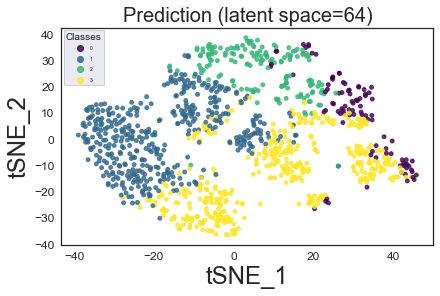

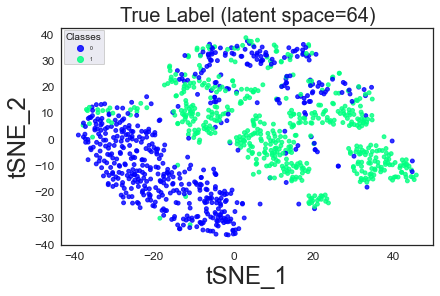

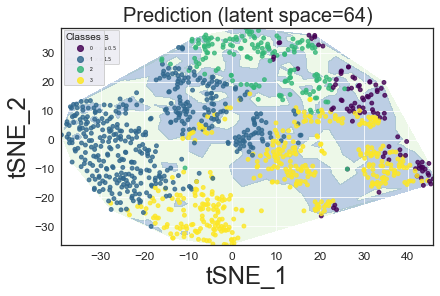

In [9]:
z_test = autoencoder_cvae.encode(X_test,Y_test)
#z_train = autoencoder_cvae.encode(X_train,Y_train)
n_clusters = 4
z_test = z_test.detach().numpy()
#z_train = z_train.detach().numpy()
y_test = Y_test.detach().numpy()
clustering = GaussianMixture(n_components=n_clusters, covariance_type='full').fit(z_test)
clustering_labels = clustering.predict(z_test)
tSNE(z_test,clustering_labels=clustering_labels,true_labels=y_test,latent_space=64,data="cells")


In [10]:
# umap(z_test,clustering_labels=clustering_labels,true_labels=y_test,latent_space=64,data="cells")

Samples of each cluster

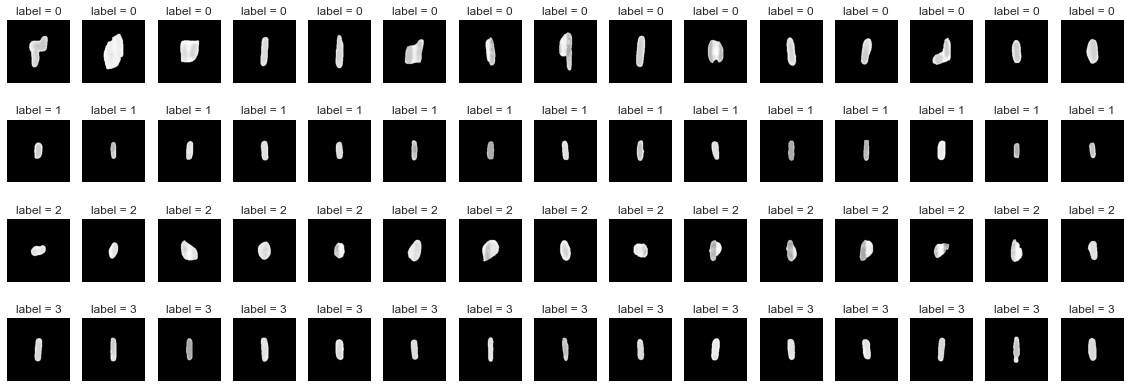

Silhouette: 0.1608, DB: 2.0215, CH: 172.1594


In [11]:
# Samples from each cluster
nb_samples = 15
l = list(set(clustering_labels))
fig, axes = plt.subplots(n_clusters,nb_samples, figsize=(20,7))
for label2 in l:
    for sample_index in range(nb_samples):
        axes[label2][sample_index].imshow(X_test[np.where(clustering_labels == label2)[0][sample_index]][0], cmap='gray')
        axes[label2][sample_index].set_title("label = "+str(label2))
        axes[label2][sample_index].grid(False)
        axes[label2][sample_index].axis('off')
        #axes[label][sample_index].set_title(f"Sample {sample_index} for cluster {label}")

plt.show()

s_16 = silhouette_score(z_test, clustering_labels)
db_16 = davies_bouldin_score(z_test, clustering_labels)
ch_16 = calinski_harabasz_score(z_test, clustering_labels)
print(f"Silhouette: {s_16:.4f}, DB: {db_16:.4f}, CH: {ch_16:.4f}")

## Wild vs BRAF

In [12]:
dataset = datasets.ImageFolder(root='cell_data_balanced_2classes_Wild_braf', transform=transform)

train_proportion = 0.8
test_proportion = 1 - train_proportion

# Calculate the number of samples for each split
total_samples = len(dataset)
train_samples = int(train_proportion * total_samples)
test_samples = total_samples - train_samples

# Use random_split to create train and test datasets with the calculated proportions
train_dataset, test_dataset = random_split(dataset, [train_samples, test_samples])

# Create DataLoader instances to load batches during training and testing
batch_size = 128
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

X_train = []
Y_train = []
for images, labels in train_loader:
    X_train.append(images)
    Y_train.append(labels)
X_train = torch.cat(X_train, dim=0)
Y_train = torch.cat(Y_train, dim=0)

X_test = []
Y_test = []
for images, labels in test_loader:
    X_test.append(images)
    Y_test.append(labels)
X_test = torch.cat(X_test, dim=0)
Y_test = torch.cat(Y_test, dim=0)

# Print shapes for verification
print("X_train shape:", X_train.shape)
print("Y_train shape:", Y_train.shape)
print("X_test shape:", X_test.shape)
print("Y_test shape:", Y_test.shape)
# for i in range(X_train.shape[0]):
#     img=X_train[i][0,:,:]
#     label = Y_train[0]
#     plt.figure(figsize=(10,10))
#     plt.imshow(img,cmap="gray")
#     print(label)
#     plt.show()


X_train shape: torch.Size([4300, 1, 192, 192])
Y_train shape: torch.Size([4300])
X_test shape: torch.Size([1076, 1, 192, 192])
Y_test shape: torch.Size([1076])


In [13]:
latent_dim=64
model = cVAE(num_labels=2, latent_dim=64,input_size=192).to(device)
print(model)


cVAE(
  (label): Embedding(2, 64)
  (encoder): Sequential(
    (0): Conv2d(1, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (1): ReLU()
    (2): Conv2d(64, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (3): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (4): ReLU()
  )
  (flatten_z_mean): Linear(in_features=294912, out_features=64, bias=True)
  (flatten_z_log_var): Linear(in_features=294912, out_features=64, bias=True)
  (softplus): Softplus(beta=1, threshold=20)
  (decode_linear): Linear(in_features=128, out_features=294912, bias=True)
  (decode_2): ConvTranspose2d(128, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
  (decode_1): ConvTranspose2d(64, 1, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
)


In [14]:
autoencoder_cvae=cVAE(num_labels=2, latent_dim=64,input_size=192)
autoencoder_cvae.load_state_dict(torch.load('./models/cVAE_Wild_BRAF_zdim_64_beta_1.0_epochs_100.pth',map_location=torch.device('cpu')))


<All keys matched successfully>

Clustering using GaussianMixture


<Figure size 432x288 with 0 Axes>

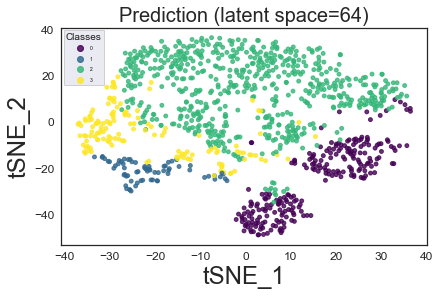

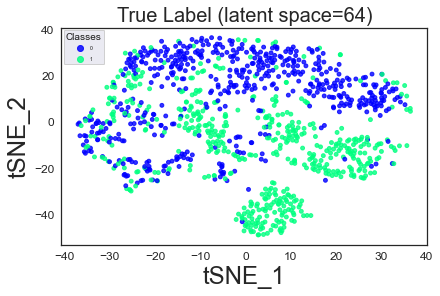

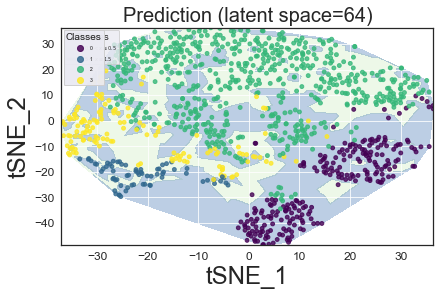

In [15]:
z_test = autoencoder_cvae.encode(X_test,Y_test)
#z_train = autoencoder_cvae.encode(X_train,Y_train)
n_clusters = 4
z_test = z_test.detach().numpy()
#z_train = z_train.detach().numpy()
y_test = Y_test.detach().numpy()
clustering = GaussianMixture(n_components=n_clusters, covariance_type='full').fit(z_test)
clustering_labels = clustering.predict(z_test)
tSNE(z_test,clustering_labels=clustering_labels,true_labels=y_test,latent_space=64,data="cells")
# umap(z_test,clustering_labels=clustering_labels,true_labels=y_test,latent_space=64,data="cells")


Samples of each cluster

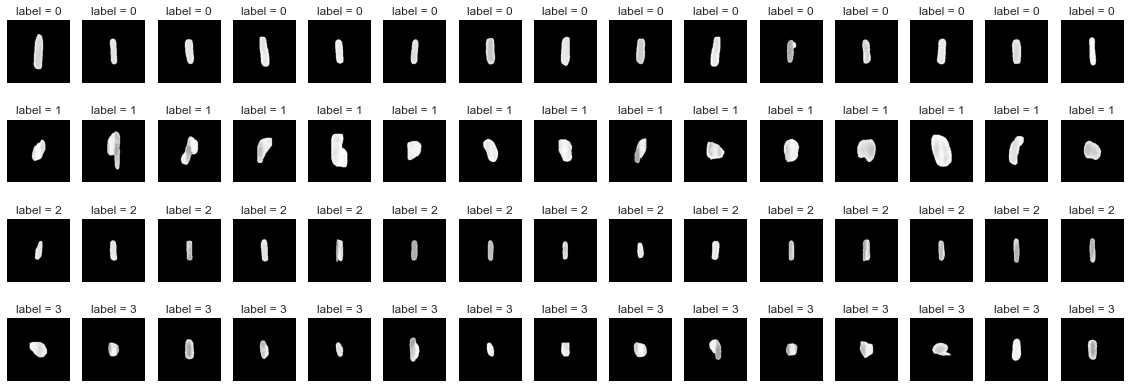

Silhouette: 0.2475, DB: 1.8054, CH: 204.8726


In [16]:
# Samples from each cluster
nb_samples = 15
l = list(set(clustering_labels))
fig, axes = plt.subplots(n_clusters,nb_samples, figsize=(20,7))
for label2 in l:
    for sample_index in range(nb_samples):
        axes[label2][sample_index].imshow(X_test[np.where(clustering_labels == label2)[0][sample_index]][0], cmap='gray')
        axes[label2][sample_index].set_title("label = "+str(label2))
        axes[label2][sample_index].grid(False)
        axes[label2][sample_index].axis('off')
        #axes[label][sample_index].set_title(f"Sample {sample_index} for cluster {label}")

plt.show()
s_16_mnist = silhouette_score(z_test, clustering_labels)
db_16_mnist = davies_bouldin_score(z_test, clustering_labels)
ch_16_mnist = calinski_harabasz_score(z_test, clustering_labels)
print(f"Silhouette: {s_16_mnist:.4f}, DB: {db_16_mnist:.4f}, CH: {ch_16_mnist:.4f}")